## ML-7. ПРОГНОЗИРОВАНИЕ БИОЛОГИЧЕСКОГО ОТВЕТА (HW-3)  

Описание домашнего задания:

Задание основано на соревновании Kaggle: Predicting a Biological Response (Прогнозирование биологического ответа). Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

В качестве метрики будем использовать F1-score. Предварительная обработка не требуется, данные уже закодированы и нормализованы.

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
%matplotlib inline
import seaborn as sns #для визуализации
plt.style.use('seaborn')

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

import warnings # скрытие сообщений об ошибках при обработке ответов
warnings.filterwarnings('ignore') # игнорируем предупреждения


C:\Users\uplot\AppData\Local\Temp\ipykernel_11000\1319609883.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Загрузка данных, знакомство с данными

In [2]:
data = pd.read_csv('data\_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# проверяем наличие пропусков
data[data.isnull().any(axis=1)]

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776


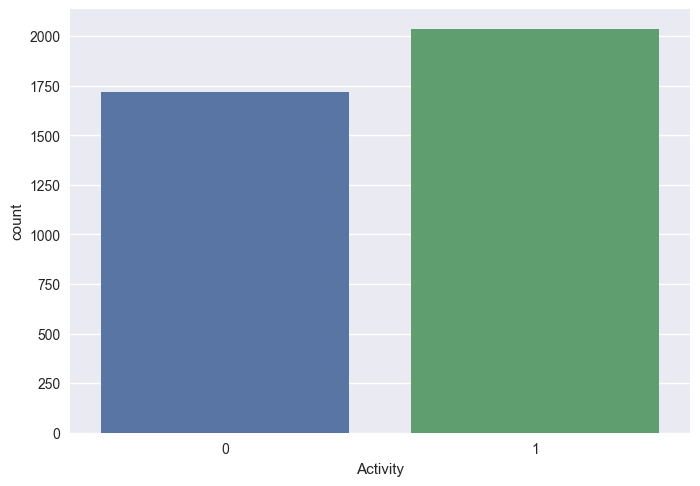

In [4]:
#Проверяем сбалансированность ключевого признака
sns.countplot(data=data, x='Activity');

### Решение задачи

* Набор данных относительно сбалансированный. Разделим данные в соотношении 80/20 на тренировочную и тестовую выборки, используя стратификацию.

* Тестовую выборку будем использовать для оценки качества обученной модели. При настройке гиперпараметров модель видеть тестовые данные не будет.

In [5]:
X = data.drop('Activity', axis=1) # матрица наблюдений
y = data['Activity'] # вектор ответов

In [6]:
# разделяем выборку на тренировочную и тестовую в соотношении 80/20,
# используем параметр stratify (стратифицированное разбиение)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    stratify=y, 
    random_state=42, 
    test_size=0.2
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3000, 1776) (751, 1776) (3000,) (751,)


# <center> Простая модель базовая оптимизация

### Логистическая регрессия  

In [7]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 50, random_state=42)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train_pred, y_train)))

y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test_pred, y_test)))

f1_score на тренировочном наборе: 0.88
f1_score на тестовом наборе: 0.78


### Случайный лес

In [8]:
#Создаем объект класса случайный лес
forest = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    max_depth=5,
    random_state=42
)

#Обучаем модель
forest.fit(X_train, y_train)

#Выводим значения метрики 
y_train_pred = forest.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 0.81
f1_score на тестовом наборе: 0.74


Промежуточный вывод: Значения метрики f1_score на тестовом наборе базовой оптимизации у логистической регрессии лучше (0.78), чем у случайного леса (0.74).

## <center> GridSearchCV

Указываем искомые гиперпараметры в виде словаря: ключами словаря являются имена настраиваемых гиперпараметров, а значениями – тестируемые настройки гиперпараметров, и передаем модель (LogisticRegression), сетку искомых параметров (param_grid), а также число фолдов, которые мы хотим использовать в кросс-валидации (пятиблочную кросс-валидацию, cv=5) и n_jobs = -1, чтобы использовать все доступные ядра для расчетов.

GridSearchCV включает в себя поиск лучших параметров и автоматическое построение новой модели на всем обучающем наборе данных, используя параметры с наилучшими значениями точности при кросс-валидации.

### Логистическая регрессия 

In [9]:
param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 7.39 s
Wall time: 39.5 s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'saga'}


Значения метрики f1_score на тестовом наборе не улучшились (0.78), расширяем сетку гиперпараметров

In [10]:
param_grid = [{'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
              'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
              'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=50), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_1.fit(X_train, y_train) 
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 10.7 s
Wall time: 7min 21s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}


In [93]:
print("Наилучшее значение метрики при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшее значение метрики при кросс-валидаци: 0.76


In [16]:
# результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.835962,0.453781,0.053191,0.006536,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.793333,0.776667,0.736667,0.765,0.74,0.762333,0.021592,5
1,6.329736,0.084327,0.048964,0.011008,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.795000,0.776667,0.736667,0.765,0.74,0.762667,0.022076,4


Метрика улучшилась незначительно (0,79), хотя время потратили гораздо больше.

Поиск по сетке не гарантирует, что мы найдем наилучшую комбинацию гиперпараметров, потому что сетка значений конечна и наилучшее значение может оказаться между заданными нами значениями.

### Случайный лес

In [11]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
            'min_samples_leaf': [5],
            'max_depth': list(np.linspace(20, 40, 5, dtype=int))
            }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 5.7 s
Wall time: 2min 39s
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


Промежуточный вывод: метрика модели случайного леса значительно улучшилась по сравнению с базовыми параметрами: f1_score на тестовом наборе: 0.74, а с использованием GridSearchCV: f1_score на тестовом наборе: 0.80, в то время как метрика модели логистической регрессии увеличилась незначительно: f1_score на тестовом наборе: 0.78, с использованием GridSearchCV: f1_score на тестовом наборе: 0.79. 

## <center> RandomizedSearchCV

В отличие от GridSearchCV, не все комбинации гиперпараметров проверяются, а только заданное количество комбинаций выбирается из указанных распределений. Количество комбинаций гиперпараметров задается n_iter.

С использованием класса RandomizedSearchCV из библиотеки scikit learn мы осуществим оптимизацию гиперпараметров для алгоритмов логистической регрессии и случайного леса, а также сравним результаты с GridSearchCV и значениями по умолчанию.

### Логистическая регресия

In [18]:
#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_grid, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 6.59 s
Wall time: 1min 18s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.01}


За 10 итераций метрику улучшить не удалось.

### Случайный лес

In [19]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_grid, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 6.31 s
Wall time: 1min 22s
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'n_estimators': 170, 'min_samples_leaf': 5, 'max_depth': 22}


Промежуточный вывод: Случайный лес в этом случае показал себя лучше метрика выше: f1_score на тестовом наборе: 0.80, а у логистической регрессии: f1_score на тестовом наборе: 0.78.

### Вывод по базовой оптимизации:
Нам удалось продемонстрировать более эффективную и быструю работу RandomizedSearchCV над GridSearchCV; при этом показатели метрики существенно выросли у модели случайного леса, тогда как метрика модели логистической регрессии практически не изменилась.

# <center> Модель продвинутой оптимизации.

## <center> Hyperopt

Интерфейс hyperopt отличается от Grid или RandomizedSearch, поэтому нам нужно создать функцию для минимизации, она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [20]:
# проверим установленную версию Hyperopt
print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


### Логистическая регресия

In [12]:
# зададим пространство поиска гиперпараметров
# Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
space={'penalty': hp.choice ('penalty', ['l1', 'l2']) ,
    'solver': hp.choice ('solver', ['liblinear', 'saga']),
    'C': hp.quniform('C', 0.01, 1, 0.01)
    }

In [13]:
# зафксируем random_state
random_state = 42
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params ['penalty'],
                'solver': params ['solver'],
                'C':params ['C']
    }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(
       **params,
        random_state=random_state,
        max_iter=50
    )

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [14]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [06:00<00:00, 18.02s/trial, best loss: -0.7904516202991784]
Наилучшие значения гиперпараметров {'C': 0.22, 'penalty': 0, 'solver': 1}
CPU times: total: 1min 49s
Wall time: 6min


In [15]:
# рассчитаем метрику для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    C = 0.22,
    penalty = 'l1',
    solver = 'saga',
    max_iter=50
 
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.78


### Случайный лес

Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [72]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [73]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [74]:
# начинаем подбор гиперпараметров
%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.seed(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [05:42<00:00, 17.10s/trial, best loss: -0.813957426489543] 
Наилучшие значения гиперпараметров {'max_depth': 23.0, 'min_samples_leaf': 4.0, 'n_estimators': 197.0}


In [62]:
# рассчитаем метрику для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.80


Вывод: Мы видим, что Hyperot не смог улучшить нашу метрику, однако мы потратили меньше времени.

## <center> Optuna

Optuna - это достаточно новый фреймворк/библиотека, разработанный специально для оптимизации гиперпараметров. Помимо байесовских алгоритмов, есть возможность удаления плохих комбинаций из рассмотрения. По умолчанию удаляет комбинации, в которых модель дает качество ниже медианы из уже рассмотренных. Optuna помогает быстрее находить лучшие гиперпараметры и работает с большинством современных известных библиотек ML, таких как scikit-learn, xgboost, PyTorch, TensorFlow, skorch, lightgbm, Keras, fast-ai и др.

In [63]:
# Проверим версию 
print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.1.1


### Случайный лес

In [64]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=random_state)
    # обучаем модель
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))

    return score

In [65]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-07-05 13:01:59,914] A new study created in memory with name: RandomForestClassifier
[I 2023-07-05 13:02:05,461] Trial 0 finished with value: 0.973170731707317 and parameters: {'n_estimators': 129, 'max_depth': 21, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.973170731707317.
[I 2023-07-05 13:02:11,009] Trial 1 finished with value: 0.8961948249619481 and parameters: {'n_estimators': 178, 'max_depth': 29, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.973170731707317.
[I 2023-07-05 13:02:14,265] Trial 2 finished with value: 0.8934102641967809 and parameters: {'n_estimators': 105, 'max_depth': 18, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.973170731707317.
[I 2023-07-05 13:02:19,819] Trial 3 finished with value: 0.9279416235937974 and parameters: {'n_estimators': 154, 'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.973170731707317.
[I 2023-07-05 13:02:23,887] Trial 4 finished with value: 0.9026763990267641 and parameters: {'n_est

CPU times: total: 1min 41s
Wall time: 1min 45s


In [66]:
# рассчитаем метрику для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80


### Логистическая регресия

In [90]:
def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  C = trial.suggest_float('C', low=0.01, high=1)

  
  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score
  
  %%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=20)

[I 2023-07-05 14:47:27,458] A new study created in memory with name: LogisticRegression


[I 2023-07-05 14:47:43,945] Trial 0 finished with value: 0.8279569892473119 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.21555408958025724}. Best is trial 0 with value: 0.8279569892473119.
[I 2023-07-05 14:47:44,483] Trial 1 finished with value: 0.808573980351295 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.10895844908168302}. Best is trial 0 with value: 0.8279569892473119.
[I 2023-07-05 14:48:02,161] Trial 2 finished with value: 0.8537976583608528 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.5928304342894335}. Best is trial 2 with value: 0.8537976583608528.
[I 2023-07-05 14:48:02,767] Trial 3 finished with value: 0.8267622461170849 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.013157205116521176}. Best is trial 2 with value: 0.8537976583608528.
[I 2023-07-05 14:48:20,008] Trial 4 finished with value: 0.831145584725537 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.237158238248118}. Best is trial 2 with value:

In [91]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.9917375900277275}
f1_score на обучающем наборе: 0.89


In [92]:
# рассчитаем метрику для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


Вывод: Optuna так же не удалось увеличить метрику, но за меньшее время, чем Hyperopt.

# Вывод

Согласно поставленной задачи, были обучены две модели с параметрами, установленным по умолчанию (Baseline):
* логистической регрессии;
* модель случайного леса.  

Значения метрик:  
**LogisticRegression** f1_score на тестовом наборе: 0.78,  
**RandomForestClassifier** f1_score на тестовом наборе: 0.74.  

Далее были подобраны гиперпараметры каждой из моделей 4 способами и каждая из моделей обучена на кросс-валидации:
* *GridSeachCV*,
* *RandomizedSearchCV*,
* *Hyperopt*,
* *Optuna*. 

В результате:

* В модели **LogisticRegression** настройки по умолчанию подобраны оптимальным образом, поэтому каждый метод поиска оптимальных гиперпараметров не показал улучшение метрики f1-score: с 0,78 увеличилась до 0,79 лишь на сетке *GridSeachCV* с подобранными наилучшиими значениями гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}.

* В модели **RandomForestClassifier** настройки по умолчанию подобраны не самым оптимальным образом, поэтому каждый метод поиска оптимальных гиперпараметров показал значительное улучшение метрики f1-score: с 0,74 увеличилась до 0,80.